# Real Estate Price Preditor

The model below predicts real estate prices based on the datasets provided in the Kaggle on-going competition "House Prices - Advanced Regression Techniques".  The original dataset contained 81 different features per row, however, this model considers primarily the features explicitly advertised on real estate apps (for example, total square footage, neighborhood/ subdivision, number of bathrooms and bedrooms).

In [270]:
import pandas as pd
import numpy as np

df = pd.read_csv('train.csv')
print(df.columns)

pd.set_option('mode.chained_assignment', None)


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Quantifying Qualitative Data

One of the most prominent features associated with the value of a home is the neighborhood.  The dataset contained a column for this feature, but the names of the neighborhoods cannot be used as input data for the machine learning model.  The median and average home prices for each neighborhood are instead used to represent the neighborhood as a quantitative value.  To avoid overfitting the model to the data set, the median and average prices of neighborhoods will be calculated after the data is split into the train and test set.

Additionally, there was a feature called 'Functional' which speaks to the overall working condition of each home at the time of sale.  A home being completely functional versus having experienced severe damage will have significant impact on the final sale price of a home, but categories are used in the original data set.  An additonal column assigned a ranked number to each home based on the 'Functional' category.  For similar reasons, the features 'KitchenQual' and 'CentralAir' were used to create corresponding features representing quantified versions of the categories.

In [271]:

# df_avg_neighborhood_price = df.groupby(['Neighborhood']).SalePrice.mean()
# df_med_neighborhood_price = df.groupby(['Neighborhood']).SalePrice.median()

# df['NeighborhoodAvgPrice'] = df['Neighborhood'].map(lambda x: df_avg_neighborhood_price[x])
# df['NeighborhoodMedPrice'] = df['Neighborhood'].map(lambda x: df_med_neighborhood_price[x])

df['NeighborhoodAvgPrice'] = 0
df['NeighborhoodMedPrice'] = 0


func_dict = {
    'Typ':7,
    'Min1':6,
    'Min2':5,
    'Mod':4,
    'Maj1':3,
    'Maj2':2,
    'Sev':1,
    'Sal':0  
}

df['FuncScore'] = df['Functional'].map(lambda x: func_dict[x])

quality_dict = {
    'Ex':5,
    'Gd':4,
    'TA':3,
    'Fa':2,
    'Po':1, 
    'No':0
}

df['KitchenQualScore'] = df['KitchenQual'].map(lambda x: quality_dict[x])

df.loc[df['BsmtQual'].isnull(),'BsmtQual'] = "No"
df['BsmtQualScore'] = df['BsmtQual'].map(lambda x: quality_dict[x])
df.loc[df['BsmtCond'].isnull(),'BsmtCond'] = "No"
df['BsmtCondScore'] = df['BsmtCond'].map(lambda x: quality_dict[x])
df.loc[df['ExterQual'].isnull(),'ExterQual'] = "No"
df['ExterQualScore'] = df['ExterQual'].map(lambda x: quality_dict[x])
df.loc[df['ExterCond'].isnull(),'ExterCond'] = "No"
df['ExterCondScore'] = df['ExterCond'].map(lambda x: quality_dict[x])

df['CentralAirScore'] = df['CentralAir'].map(lambda x: 1 if x.title().strip() == 'Y' else 0)

### Features Of Interest

The following model is based on the features below.

In [272]:
features_of_interest = [
    'NeighborhoodAvgPrice',
    'NeighborhoodMedPrice',
    '1stFlrSF',
    '2ndFlrSF',
    'TotalBsmtSF',
    'OverallQual',
    'OverallCond',
    'FuncScore',
    'TotRmsAbvGrd',
    'BedroomAbvGr',
    'LotArea',
    'GarageArea',
    'KitchenQualScore',
    'BsmtQualScore',
    'BsmtCondScore',
    'CentralAirScore',
    'FullBath',
    'BsmtFullBath',
    'BsmtHalfBath',
    'HalfBath',
    'ExterQualScore',
    'ExterCondScore',
    'SalePrice'
]

df_foi = df[features_of_interest]
df_foi['Neighborhood'] = df['Neighborhood']




### Cleaning & Standardizing Data

Missing values must be considered if they exist in a data set.  None exist in the data set to be used to split, train and test the machine learning model.

All the features, except 'Neighborhood', will be standardized by computing the respective Z-scores.  Data should be standardized to prevent the features with greater variance across values from having more influence in machine learning model.


In [273]:
for feature in features_of_interest:
    print(f"Number of null values for {feature}:", df_foi.loc[df_foi[feature].isnull(), feature].count())
    

Number of null values for NeighborhoodAvgPrice: 0
Number of null values for NeighborhoodMedPrice: 0
Number of null values for 1stFlrSF: 0
Number of null values for 2ndFlrSF: 0
Number of null values for TotalBsmtSF: 0
Number of null values for OverallQual: 0
Number of null values for OverallCond: 0
Number of null values for FuncScore: 0
Number of null values for TotRmsAbvGrd: 0
Number of null values for BedroomAbvGr: 0
Number of null values for LotArea: 0
Number of null values for GarageArea: 0
Number of null values for KitchenQualScore: 0
Number of null values for BsmtQualScore: 0
Number of null values for BsmtCondScore: 0
Number of null values for CentralAirScore: 0
Number of null values for FullBath: 0
Number of null values for BsmtFullBath: 0
Number of null values for BsmtHalfBath: 0
Number of null values for HalfBath: 0
Number of null values for ExterQualScore: 0
Number of null values for ExterCondScore: 0
Number of null values for SalePrice: 0


In [274]:
from sklearn.preprocessing import StandardScaler


scaler = preprocessing.StandardScaler()
for feature in features_of_interest:
    df_foi[feature] = scaler.fit_transform(df_foi[feature].values.reshape(-1,1))


### Splitting Data Into Train And Test Sets

To avoid overfitting the model to the entire data set, the 'NeighborhoodAvgPrice' and 'NeighborhoodMedPrice' are computed after the data set has been split into train and test sets.  

In [275]:
from sklearn.model_selection import train_test_split


y = df_foi['SalePrice']
X = df_foi

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

df_avg_neighborhood_price = X_train.groupby(['Neighborhood']).SalePrice.mean()
df_med_neighborhood_price = X_train.groupby(['Neighborhood']).SalePrice.median()

X_train['NeighborhoodAvgPrice'] = X_train['Neighborhood'].map(lambda x: df_avg_neighborhood_price[x])
X_train['NeighborhoodMedPrice'] = X_train['Neighborhood'].map(lambda x: df_med_neighborhood_price[x])
X_train.drop(columns=['Neighborhood', 'SalePrice'], inplace=True)

X_test['NeighborhoodAvgPrice'] = X_test['Neighborhood'].map(lambda x: df_avg_neighborhood_price[x])
X_test['NeighborhoodMedPrice'] = X_test['Neighborhood'].map(lambda x: df_med_neighborhood_price[x])
X_test.drop(columns=['Neighborhood', 'SalePrice'], inplace=True)


### Feature Exploration

Plotting the different features of interest (standardized) against the sale price suggests that there may be a quadratic relationship between these features and sale price.  Consequently, a Polynomial Linear Regression model was used for the first Machine Learning model.

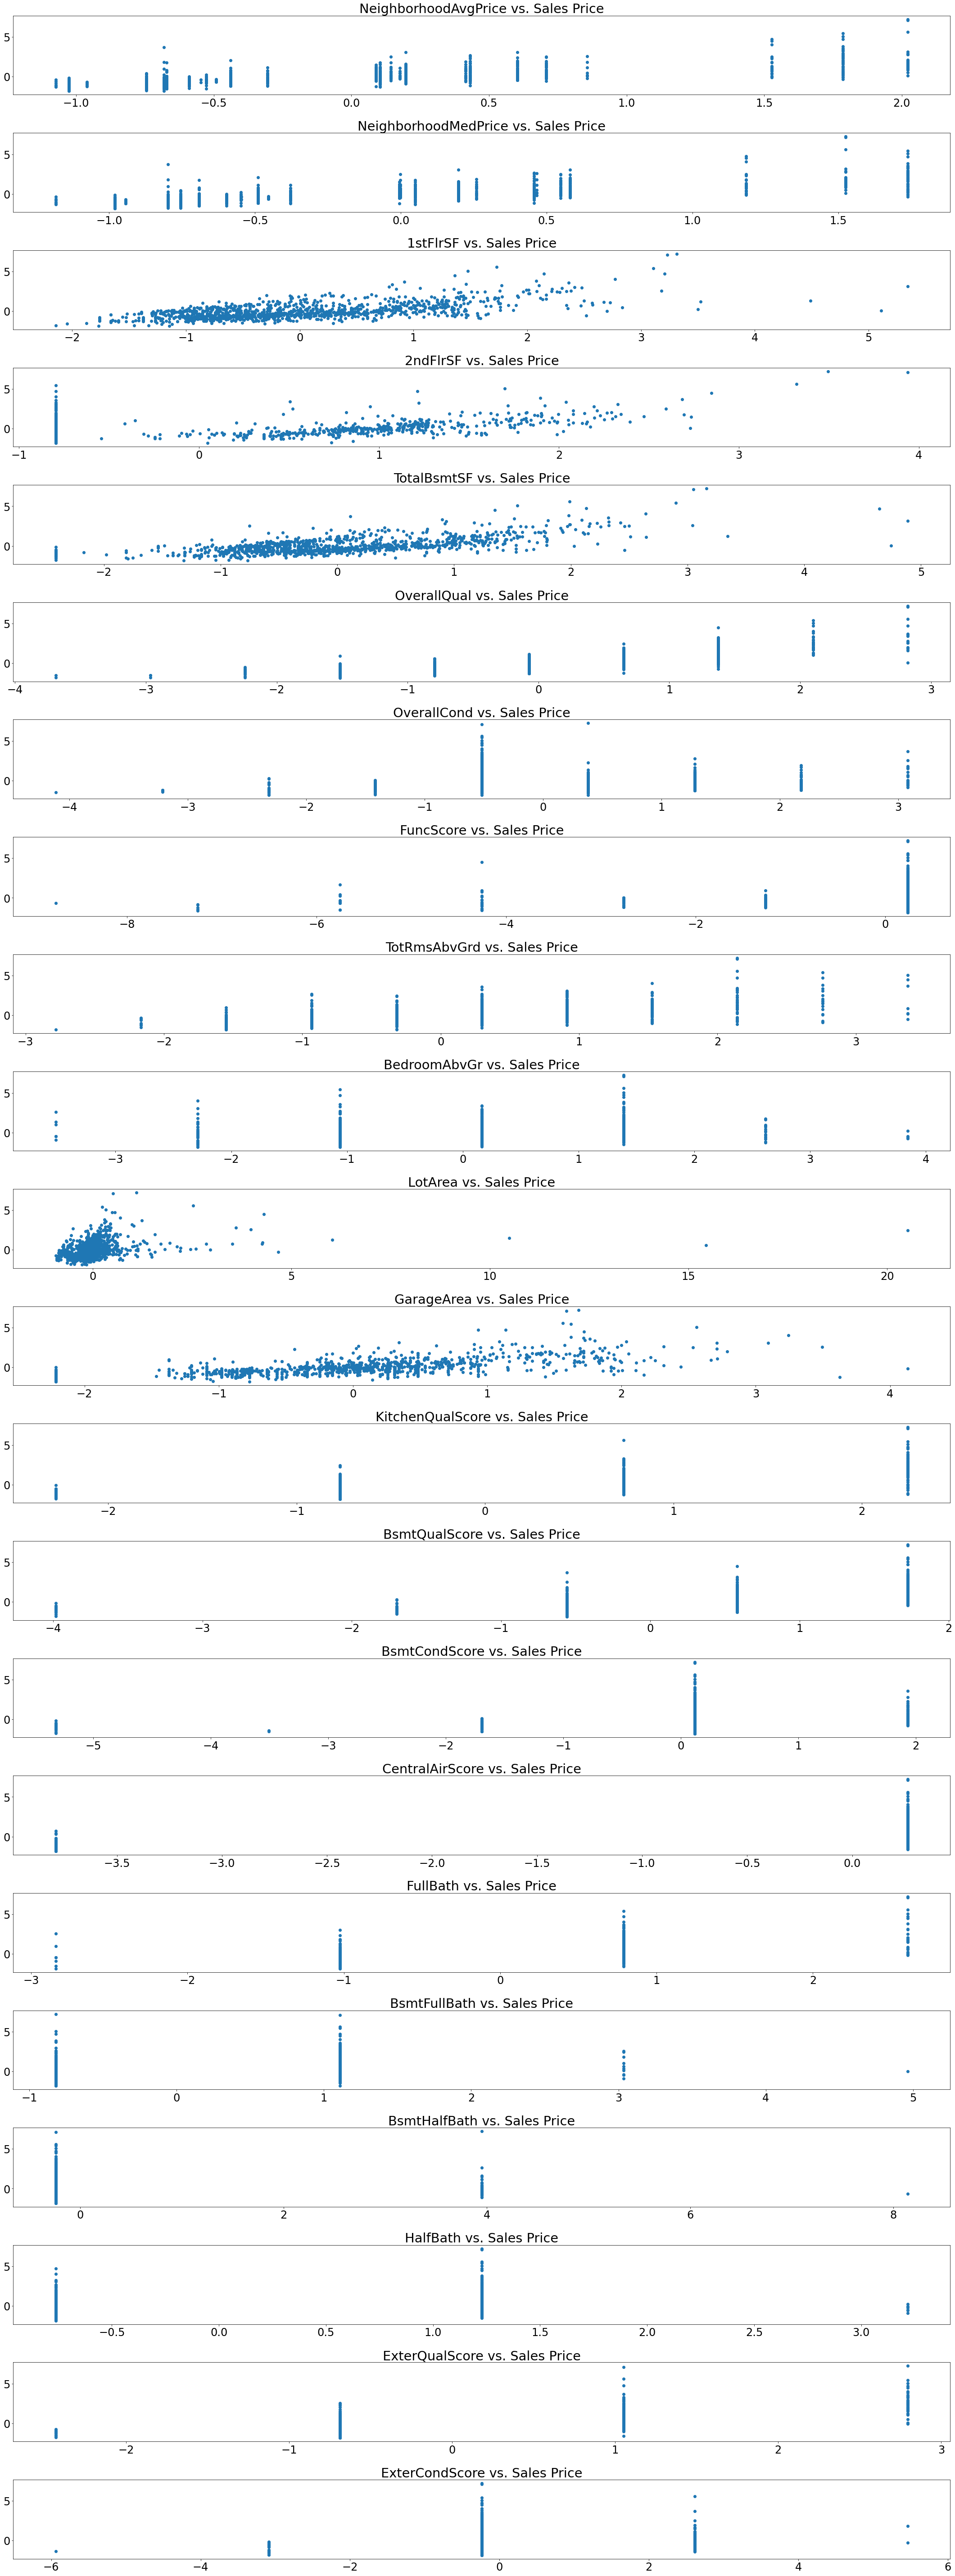

In [276]:
import matplotlib.pyplot as plt

# def plot_scatter(X, y):
#     plt.scatter(X, y, alpha=0.5)
#     plt.title("Scatter Plot of {} vs. {}".format(X.name, y.name))
#     plt.show
    
features_of_interest.remove('SalePrice')

fig, axs = plt.subplots(len(features_of_interest), figsize=(30, 80))

for feature in features_of_interest:
    axs[features_of_interest.index(feature)].scatter(x=X_train[feature], y=y_train)
    axs[features_of_interest.index(feature)].set_title("{} vs. Sales Price".format(feature, pad=40))

plt.rc('font', size=24)
fig.tight_layout()
plt.show()


### Training And Testing The Polynomial Linear Regression Model


In [277]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train) 
model = LinearRegression()
model.fit(X_poly, y_train) 

X_test_poly = poly.transform(X_test)
y_test_predictions = model.predict(X_test_poly)
rmse = np.sqrt(mean_squared_error(y_test,y_test_predictions))
r2 = r2_score(y_test,y_test_predictions)
print('Test RMSE: ', rmse)
print('Test R2: ', r2)


Test RMSE:  0.5923917267476051
Test R2:  0.5517763359676903
